# Speeding up the solvers

This notebook contains a collection of tips on how to speed up the solvers

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import matplotlib.pyplot as plt

You should consider upgrading via the '/Users/vsulzer/Documents/Energy_storage/PyBaMM/.tox/dev/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Choosing a solver

Since it is very easy to switch which solver is used for the model, we recommend you try different solvers for your particular use case. In general, the `CasadiSolver` is the fastest.

Once you have found a good solver, you can further improve performance by trying out different values for the `method`, `rtol`, and `atol` arguments. Further options are sometimes available, but are solver specific. See [solver API docs](https://pybamm.readthedocs.io/en/latest/source/solvers/index.html) for details.

## Choosing and optimizing CasadiSolver settings

## Handling instabilities

If the solver is taking a lot of steps, possibly failing with a `max_steps` error, and the error persists with different solvers, this suggests a problem with the model itself. This can be due to a few things:

- A singularity in the model (such as division by zero). Solve up to the time where the model fails, and plot some variables to see if they are going to infinity. You can then narrow down the source of the problem.
- High model stiffness. Again, plot different variables to identify which variables or parameters may be causing problems. To reduce stiffness, all dimensionless parameter values should be as close to 1 as possible.
- Non-differentiable functions (see [below](#Smooth-approximations-to-non-differentiable-functions))

If none of these fixes work, we are interested in finding out why - please get in touch!

### Smooth approximations to non-differentiable functions

Some functions, such as `minimum`, `maximum`, `heaviside`, and `abs`, are discontinuous and/or non-differentiable (their derivative is discontinuous). Adaptive solvers can deal with this discontinuity, but will take many more steps close to the discontinuity in order to resolve it. Therefore, using smooth approximations instead can reduce the number of steps taken by the solver, and hence the integration time. See [this post](https://discourse.julialang.org/t/handling-instability-when-solving-ode-problems/9019/5) for more details.

Here is an example using the `maximum` function. The function `maximum(x,1)` is continuous but non-differentiable at `x=1`, where its derivative jumps from 0 to 1. However, we can approximate it using the [`softplus` function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Softplus), which is smooth everywhere and is sometimes used in neural networks as a smooth approximation to the RELU activation function. The `softplus` function is given by
$$
s(x,y;k) = \frac{\log(\exp(kx)+\exp(ky))}{k},
$$
where `k` is a strictly positive smoothing (or sharpness) parameter. The larger the value of `k`, the better the approximation but the stiffer the term (exp blows up quickly!). Usually, a value of `k=10` is a good middle ground.

In PyBaMM, you can either call the `softplus` function directly, or change `pybamm.settings.max_smoothing` to automatically replace all your calls to `pybamm.maximum` with `softplus`.

In [2]:
x = pybamm.Variable("x")
y = pybamm.Variable("y")

# Normal maximum
print("Exact maximum:", pybamm.maximum(x,y))

# Softplus
print("Softplus (k=10):", pybamm.softplus(x,y,10))

# Changing the setting to call softplus automatically
pybamm.settings.max_smoothing = 20
print("Softplus (k=20):", pybamm.maximum(x,y))

# All smoothing parameters can be changed at once
pybamm.settings.set_smoothing_parameters(30)
print("Softplus (k=30):", pybamm.maximum(x,y))

# Change back
pybamm.settings.set_smoothing_parameters("exact")
print("Exact maximum:", pybamm.maximum(x,y))

Exact maximum: maximum(x, y)
Softplus (k=10): log(exp(10.0 * x) + exp(10.0 * y)) / 10.0
Softplus (k=20): log(exp(20.0 * x) + exp(20.0 * y)) / 20.0
Softplus (k=30): log(exp(30.0 * x) + exp(30.0 * y)) / 30.0
Exact maximum: maximum(x, y)


Here is the plot of softplus with different values of `k`

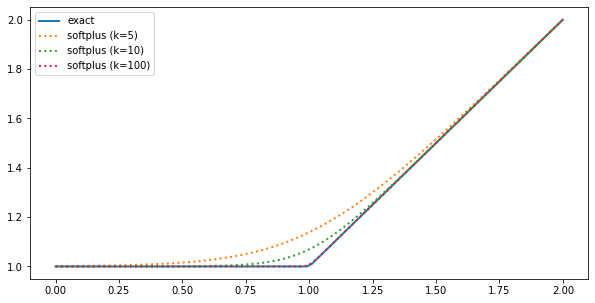

In [3]:
pts = pybamm.linspace(0, 2, 100)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(pts.evaluate(), pybamm.maximum(pts,1).evaluate(), lw=2, label="exact")
ax.plot(pts.evaluate(), pybamm.softplus(pts,1,5).evaluate(), ":", lw=2, label="softplus (k=5)")
ax.plot(pts.evaluate(), pybamm.softplus(pts,1,10).evaluate(), ":", lw=2, label="softplus (k=10)")
ax.plot(pts.evaluate(), pybamm.softplus(pts,1,100).evaluate(), ":", lw=2, label="softplus (k=100)")
ax.legend()

Solving a model with the exact maximum, and smooth approximations, demonstrates a clear speed-up even for a very simple model

In [4]:
model_exact = pybamm.BaseModel()
model_exact.rhs = {x: pybamm.maximum(x, 1)}
model_exact.initial_conditions = {x: 0.5}
model_exact.variables = {"x": x, "max(x,1)": pybamm.maximum(x, 1)}

model_smooth = pybamm.BaseModel()
k = pybamm.InputParameter("k")
model_smooth.rhs = {x: pybamm.softplus(x, 1, k)}
model_smooth.initial_conditions = {x: 0.5}
model_smooth.variables = {"x": x, "max(x,1)": pybamm.softplus(x, 1, k)}

solver = pybamm.CasadiSolver(mode="fast")

# Exact solution
timer = pybamm.Timer()
time = 0
for _ in range(100):
    exact_sol = solver.solve(model_exact, [0, 2])
    # Report integration time, which is the time spent actually doing the integration
    time += exact_sol.integration_time
print("Exact:", timer.format(time/100))
sols = [exact_sol]

ks = [5, 10, 100]
for k in ks:
    time = 0
    for _ in range(100):
        sol = solver.solve(model_smooth, [0, 2], inputs={"k": k})
        time += sol.integration_time
    print(f"Smooth, k={k}:", timer.format(time/100))
    sols.append(sol)

pybamm.dynamic_plot(sols, ["x", "max(x,1)"], labels=["exact"] + [f"smooth (k={k})" for k in ks]);

Exact: 262.878 us
Smooth, k=5: 259.492 us
Smooth, k=10: 221.944 us
Smooth, k=100: 262.987 us


interactive(children=(FloatSlider(value=0.0, description='t', max=2.0, step=0.02), Output()), _dom_classes=('w…

#### Other smooth approximations

Here are the other smooth approximations for the other non-smooth functions:

In [5]:
pybamm.settings.set_smoothing_parameters(10)
print("Smooth minimum (softminus):\t {!s}".format(pybamm.minimum(x,y)))
print("Smooth heaviside (sigmoid):\t {!s}".format(x < y))
print("Smooth absolute value: \t\t {!s}".format(abs(x)))
pybamm.settings.set_smoothing_parameters("exact")

Smooth minimum (softminus):	 log(exp(-10.0 * x) + exp(-10.0 * y)) / -10.0
Smooth heaviside (sigmoid):	 (1.0 + tanh(10.0 * (y - x))) / 2.0
Smooth absolute value: 		 x * (exp(10.0 * x) - exp(-10.0 * x)) / (exp(10.0 * x) + exp(-10.0 * x))
